Driver Identification System using Deep Learning

In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

data = pd.read_csv('full_data_test.csv')
columns2=["Long_Term_Fuel_Trim_Bank1","Intake_air_pressure","Accelerator_Pedal_value","Fuel_consumption","Torque_of_friction","Maximum_indicated_engine_torque","Engine_torque","Calculated_LOAD_value",
"Activation_of_Air_compressor","Engine_coolant_temperature","Transmission_oil_temperature","Wheel_velocity_front_left-hand","Wheel_velocity_front_right-hand","Wheel_velocity_rear_left-hand",
"Torque_converter_speed"]


#For Anamoly Detection
from sklearn import svm
ano_det = svm.OneClassSVM(nu=0.1,kernel="rbf",gamma=0.1)
ano_det.fit(data[columns2])




OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.1, kernel='rbf',
      max_iter=-1, nu=0.1, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

Prepocessing of Data

In [2]:
classes=['A','B','C','D','E','F','G','H','I','J']


drivers =[]
for c in classes:
    drivers.append(data[data['Class']==c])
dataa=[]
for c in range(len(drivers)):
    nt=0
    nv=0
    drivers[c]=drivers[c].reset_index(drop=True)
    idxs=drivers[c][drivers[c]['Time(s)']==1].index.values
    for i in range(len(idxs)):
        if i <(len(idxs)-1):
            nt=nt+1
            dataa.append(drivers[c][idxs[i]:idxs[i+1]])
        if i==(len(idxs)-1):
            nv=nv+1
            dataa.append(drivers[c][idxs[i]:])
    print("Driver : "+str(c)+" number of trips :"+str(len(idxs))+ "  For Train : "+str(nt)+"  For valid :"+str(nv))


drivers=[]
ss=0
for i in range(len(dataa)):
    #print(n)
    n=int(len(dataa[i])/60)
    #print(" Drive "+str(i)+" contains "+str(n)+" subdriversets")
    dd=0
    for j in range(n):
        #print(j)
        temp=dataa[i][dd:dd+60]
        temp=temp.reset_index(drop=True)
        drivers.append(temp)
        ss=ss+1
        dd=dd+60
print("total is "+str(ss))

  

samples = list()
labels=list()
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(data[columns2].values)
for c in drivers:
    labels.append(c['Class'][0])
    del c['Class']
    del c['Time(s)']
    samples.append(scaler.transform(c[columns2].values))
data = np.array(samples)
print(data.shape)

Driver : 0 number of trips :4  For Train : 3  For valid :1
Driver : 1 number of trips :6  For Train : 5  For valid :1
Driver : 2 number of trips :4  For Train : 3  For valid :1
Driver : 3 number of trips :6  For Train : 5  For valid :1
Driver : 4 number of trips :4  For Train : 3  For valid :1
Driver : 5 number of trips :4  For Train : 3  For valid :1
Driver : 6 number of trips :4  For Train : 3  For valid :1
Driver : 7 number of trips :4  For Train : 3  For valid :1
Driver : 8 number of trips :4  For Train : 3  For valid :1
Driver : 9 number of trips :4  For Train : 3  For valid :1
total is 1551
(1551, 60, 15)


In [3]:
data.shape

(1551, 60, 15)

In [4]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(labels)
labels=le.transform(labels) 


from keras import optimizers


# Doing the cross validation and training the model

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=31)
X_test, X_predict, y_test, y_predict = train_test_split(X_test, y_test, test_size=0.1, random_state=31)

In [5]:
X_train.shape

(1085, 60, 15)

In [6]:
X_test.shape

(419, 60, 15)

In [7]:
X_predict.shape

(47, 60, 15)

In [8]:
data.shape[1]

60

In [9]:
data.shape[2]

15

Implement FCN-LSTM

In [10]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import *

from keras.models import Model
from keras.layers import Input, PReLU, Dense, LSTM, multiply, concatenate, Activation
from keras.layers import Conv1D, BatchNormalization, GlobalAveragePooling1D, Permute, Dropout
from keras.callbacks import ModelCheckpoint
from tensorflow import keras
from tensorflow.keras import layers


ip = Input(shape=(data.shape[1], data.shape[2]))

x = Permute((2, 1))(ip) # dimension shuffle
x=LSTM(10)(x)
x = Dropout(0.8)(x)


y = Conv1D(128, 8, padding='same', kernel_initializer='he_uniform')(ip)
y = BatchNormalization()(y)
y = Activation('relu')(y)
y = Conv1D(256, 5, padding='same', kernel_initializer='he_uniform')(y)
y = BatchNormalization()(y)
y = Activation('relu')(y)
y = Conv1D(128, 3, padding='same', kernel_initializer='he_uniform')(y)
y = BatchNormalization()(y)
y = Activation('relu')(y)
y = GlobalAveragePooling1D()(y)

x = concatenate([x, y])
out = Dense(10, activation='sigmoid')(y)
model = Model(ip, out)

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 60, 15)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 60, 128)           15488     
_________________________________________________________________
batch_normalization (BatchNo (None, 60, 128)           512       
_________________________________________________________________
activation (Activation)      (None, 60, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 60, 256)           164096    
_________________________________________________________________
batch_normalization_1 (Batch (None, 60, 256)           1024      
_________________________________________________________________
activation_1 (Activation)    (None, 60, 256)           0     

Train the Model

In [12]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=10, batch_size=128, verbose=2)

Epoch 1/10
9/9 - 70s - loss: 1.8769 - accuracy: 0.3484 - val_loss: 3.5317 - val_accuracy: 0.1718
Epoch 2/10
9/9 - 2s - loss: 1.3129 - accuracy: 0.5410 - val_loss: 3.9070 - val_accuracy: 0.1957
Epoch 3/10
9/9 - 2s - loss: 1.0909 - accuracy: 0.6479 - val_loss: 3.5811 - val_accuracy: 0.1718
Epoch 4/10
9/9 - 2s - loss: 0.9296 - accuracy: 0.7051 - val_loss: 3.1083 - val_accuracy: 0.2339
Epoch 5/10
9/9 - 2s - loss: 0.8084 - accuracy: 0.7641 - val_loss: 2.7938 - val_accuracy: 0.2745
Epoch 6/10
9/9 - 2s - loss: 0.7218 - accuracy: 0.7825 - val_loss: 2.3922 - val_accuracy: 0.2912
Epoch 7/10
9/9 - 2s - loss: 0.6469 - accuracy: 0.8055 - val_loss: 2.0809 - val_accuracy: 0.3556
Epoch 8/10
9/9 - 2s - loss: 0.6043 - accuracy: 0.8194 - val_loss: 1.7873 - val_accuracy: 0.4057
Epoch 9/10
9/9 - 2s - loss: 0.5496 - accuracy: 0.8461 - val_loss: 1.5236 - val_accuracy: 0.4845
Epoch 10/10
9/9 - 2s - loss: 0.5290 - accuracy: 0.8461 - val_loss: 1.3940 - val_accuracy: 0.4869


In [13]:
model.save('Driver_Profiling.h5') 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


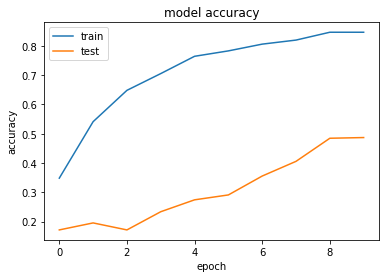

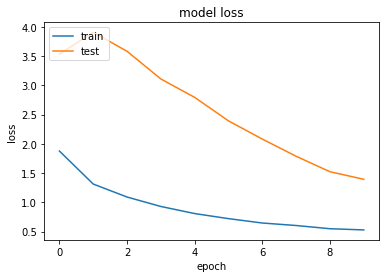

In [14]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
 #Adding some anomalies to the data to test the performance of the model
import random
rates=[0,0.01,0.1,0.3,0.5]
rows=[1,10]
sensors=[7]

results=pd.DataFrame(columns=["Rate","Rows","Sensors","Accuracy"])
for rate in rates:
      for row in rows:
        for sensor in sensors:
            X_test2=X_test.copy()
            total=X_test.shape[0]*X_test.shape[1]*X_test.shape[2]
            total=int(311*rate)
            n=sensor
            nrows=row
            for i in range(total):
                if(i%10000==0):
                    print(i)
                fst=random.randint(0,X_test.shape[0]-1)
                snd=random.randint(0,X_test.shape[1]-nrows)
                trh2=random.sample(range(0, X_test.shape[2]), n)
                for j in range(n):
                    for jj in range(nrows):
                        X_test2[fst][snd+jj][trh2[j]]=X_test2[fst][snd+jj][trh2[j]]+3000
            acc=round(model.evaluate(X_test2, y_test)[1]*100,2)
            results = results.append({'Rate': str(rate*100)+"%",'Rows': str(row)+"",'Sensors': str(sensor)+"",'Accuracy': acc}, ignore_index=True)
    #model.evaluate(X_test2, y_test)


print(results)

14/14 [==============================] - 0s 21ms/step - loss: 1.3940 - accuracy: 0.4869
0
14/14 [==============================] - 0s 13ms/step - loss: 5.7976 - accuracy: 0.4821
0
14/14 [==============================] - 0s 18ms/step - loss: 20.8400 - accuracy: 0.4845
0
14/14 [==============================] - 0s 18ms/step - loss: 47.4985 - accuracy: 0.4630
0
14/14 [==============================] - 0s 18ms/step - loss: 191.8286 - accuracy: 0.4582
0
14/14 [==============================] - 0s 18ms/step - loss: 116.6216 - accuracy: 0.3962
0
14/14 [==============================] - 0s 13ms/step - loss: 725.3673 - accuracy: 0.4177
0
14/14 [==============================] - 0s 14ms/step - loss: 191.0176 - accuracy: 0.3699
0
14/14 [==============================] - 0s 18ms/step - loss: 991.8760 - accuracy: 0.3532
    Rate Rows Sensors  Accuracy
0     0%    1       7     48.69
1     0%   10       7     48.69
2   1.0%    1       7     48.21
3   1.0%   10       7     48.45
4  10.0%    1       

Deployment Part

In [16]:
model = keras.models.load_model('Driver_Profiling.h5')

In [17]:
Live_Data= np.expand_dims(X_predict[10],axis=0)

In [18]:
X_predict[1].shape

(60, 15)

In [19]:
Live_Data.shape

(1, 60, 15)

In [20]:
pred = model.predict(Live_Data)
pred # by mymodel

array([[0.84153163, 0.07260692, 0.7982757 , 0.67956305, 0.4729914 ,
        0.438281  , 0.47081518, 0.09413144, 0.17564386, 0.53980017]],
      dtype=float32)

In [21]:
np.argmax(pred)# by mymodel

0

In [22]:
y_predict[10] # stored value / actual values

5

In [23]:
y_predict

array([1, 0, 3, 4, 6, 4, 3, 1, 9, 5, 5, 8, 9, 4, 1, 3, 0, 1, 6, 7, 1, 3,
       9, 8, 2, 6, 8, 3, 5, 1, 3, 1, 7, 3, 5, 7, 5, 1, 1, 6, 9, 0, 2, 0,
       1, 3, 6], dtype=int64)